<a href="https://colab.research.google.com/github/mili189/ASK2026_Semiconductor_FDC/blob/main/%EA%B7%9C%EC%88%9C/%20Preprocess_v4_%EC%A0%81%EC%9A%A9_LSTM%2C_TranAD%2C_1D_ResNet_%EC%9E%AC%ED%95%99%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
#1 드라이브 연결
from google.colab import drive
import os

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# ==========================================
# 1. 라이브러리 및 환경 설정
# ==========================================
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
import os
import warnings

warnings.filterwarnings('ignore')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ==========================================
# 2. 통합 데이터 전처리 (Unified Dataset)
# ==========================================
file_path = ("/content/drive/MyDrive/Colab Notebooks/data set/MACHINE_data/MACHINE_Data.xlsx")
if os.path.exists(file_path):
    df = pd.read_excel(file_path) if file_path.endswith('.xlsx') else pd.read_csv(file_path)
else:
    df = pd.DataFrame()

sensor_cols = [
    'BCl3 Flow', 'Cl2 Flow', 'RF Btm Pwr', 'RF Btm Rfl Pwr', 'Endpt A',
    'He Press', 'Pressure', 'RF Tuner', 'RF Load', 'RF Phase Err',
    'RF Pwr', 'RF Impedance', 'TCP Tuner', 'TCP Phase Err',
    'TCP Impedance', 'TCP Top Pwr', 'TCP Rfl Pwr', 'TCP Load', 'Vat Valve'
]

def create_sequences_with_ids(df_target, wafer_col, sensor_cols, seq_len, scaler=None, is_train=True):
    data_values = df_target[sensor_cols].values
    if is_train:
        if scaler is None: scaler = MinMaxScaler()
        data_scaled = scaler.fit_transform(data_values)
    else:
        data_scaled = scaler.transform(data_values)

    df_scaled = pd.DataFrame(data_scaled, columns=sensor_cols, index=df_target.index)
    df_scaled[wafer_col] = df_target[wafer_col].values

    all_sequences, all_wafer_ids = [], []
    for wafer in df_scaled[wafer_col].unique():
        wafer_data = df_scaled[df_scaled[wafer_col] == wafer][sensor_cols].values
        if len(wafer_data) < seq_len: continue
        for i in range(len(wafer_data) - seq_len + 1):
            all_sequences.append(wafer_data[i : i + seq_len])
            all_wafer_ids.append(wafer)

    if len(all_sequences) == 0: return np.array([]), np.array([]), scaler
    return np.array(all_sequences), np.array(all_wafer_ids), scaler



# --- 데이터 통합 및 분할 ---
datasets = {}
target_experiments = ['l29', 'l31', 'l33']
SEQ_LEN = 32
TRAIN_RATIO = 0.7

print(f"🚀 Creating Unified Dataset from: {target_experiments}")

# 통합 데이터 필터링
combined_mask = df['Wafer_ID'].str.contains('|'.join(target_experiments), case=False, na=False)
combined_df = df[combined_mask]

# ID 셔플 및 분할
all_normal_ids = combined_df[combined_df['Label'] == 'Normal']['Wafer_ID'].unique()
all_fault_ids = combined_df[combined_df['Label'] == 'Fault']['Wafer_ID'].unique()

np.random.seed(42)
np.random.shuffle(all_normal_ids)

n_train = int(len(all_normal_ids) * TRAIN_RATIO)
train_ids = all_normal_ids[:n_train]
test_norm_ids = all_normal_ids[n_train:]

# 데이터프레임 분할
df_train = combined_df[combined_df['Wafer_ID'].isin(train_ids)]
df_test_norm = combined_df[combined_df['Wafer_ID'].isin(test_norm_ids)]
df_test_fault = combined_df[combined_df['Wafer_ID'].isin(all_fault_ids)]

# 시퀀스 생성
X_train, ids_train, global_scaler = create_sequences_with_ids(df_train, 'Wafer_ID', sensor_cols, SEQ_LEN, scaler=None, is_train=True)
X_test_norm, ids_test_norm, _ = create_sequences_with_ids(df_test_norm, 'Wafer_ID', sensor_cols, SEQ_LEN, scaler=global_scaler, is_train=False)
X_test_fault, ids_test_fault, _ = create_sequences_with_ids(df_test_fault, 'Wafer_ID', sensor_cols, SEQ_LEN, scaler=global_scaler, is_train=False)

# 사용자가 제공한 get_data_loaders 함수가 작동하도록 딕셔너리에 저장
datasets['Unified'] = {
    'X_train': X_train,
    'X_test_norm': X_test_norm,
    'ids_test_norm': ids_test_norm,
    'X_test_fault': X_test_fault,
    'ids_test_fault': ids_test_fault
}
print("✅ Unified Dataset Prepared.")


Using device: cpu
🚀 Creating Unified Dataset from: ['l29', 'l31', 'l33']
✅ Unified Dataset Prepared.


In [19]:
# ==========================================
# 3. 유틸리티 함수 (데이터 로드, 집계, 시각화)
# ==========================================
def get_data_loaders(exp_id, datasets_dict, batch_size=32):
    print(f"\n📊 [Data Setup] Experiment: {exp_id}")
    data = datasets_dict[exp_id]

    # 데이터 추출
    X_train = data['X_train']
    X_test_norm = data['X_test_norm']
    ids_test_norm = data['ids_test_norm']
    X_test_fault = data['X_test_fault']
    ids_test_fault = data['ids_test_fault']

    # Tensor 변환
    train_tensor = torch.FloatTensor(X_train).to(device)
    test_norm_tensor = torch.FloatTensor(X_test_norm).to(device)

    if len(X_test_fault) > 0:
        test_fault_tensor = torch.FloatTensor(X_test_fault).to(device)
    else:
        test_fault_tensor = torch.FloatTensor([]).to(device)

    # DataLoader (Train only)
    train_loader = DataLoader(TensorDataset(train_tensor), batch_size=batch_size, shuffle=True)

    return train_loader, (test_norm_tensor, ids_test_norm), (test_fault_tensor, ids_test_fault)

def aggregate_wafer_scores(window_scores, wafer_ids, method='max'):
    # DataFrame핑하여 GroupBy 연산
    df_temp = pd.DataFrame({'Wafer_ID': wafer_ids, 'Score': window_scores})

    if method == 'max':
        grouped = df_temp.groupby('Wafer_ID')['Score'].max()
    else:
        grouped = df_temp.groupby('Wafer_ID')['Score'].mean()

    return grouped.index.values, grouped.values

def visualize_results(model_name, exp_id, scores, labels, threshold):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    plt.suptitle(f"[{exp_id}] {model_name} Performance (Wafer-Level)", fontsize=16, fontweight='bold')

    # Confusion Matrix
    preds = (scores > threshold).astype(int)
    cm = confusion_matrix(labels, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0],
                xticklabels=['Normal', 'Fault'], yticklabels=['Normal', 'Fault'])
    axes[0].set_title("Confusion Matrix")

    # Scatter Plot (Wafer Scores)
    normal_idx = np.where(labels == 0)[0]
    fault_idx = np.where(labels == 1)[0]

    axes[1].scatter(normal_idx, scores[normal_idx], color='blue', label='Normal', alpha=0.6, s=20)
    axes[1].scatter(fault_idx, scores[fault_idx], color='red', label='Fault', alpha=0.6, s=20)
    axes[1].axhline(y=threshold, color='green', linestyle='--', label='Threshold')
    axes[1].set_title("Wafer Anomaly Scores")
    axes[1].legend()

    # ROC Curve
    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    axes[2].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.4f}')
    axes[2].plot([0, 1], [0, 1], color='navy', linestyle='--')
    axes[2].set_title("ROC Curve")
    axes[2].legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def evaluate_performance(model_name, exp_id, scores, labels):
    precision, recall, thresholds = precision_recall_curve(labels, scores)
    with np.errstate(divide='ignore', invalid='ignore'):
        f1_scores = 2 * recall * precision / (recall + precision)
    f1_scores = np.nan_to_num(f1_scores)

    best_idx = np.argmax(f1_scores)
    best_f1 = f1_scores[best_idx]
    best_thresh = thresholds[best_idx]

    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)

    print(f"\n📌 [{model_name} - {exp_id}] Wafer-Level Summary")
    print(f"   - AUROC         : {roc_auc:.4f}")
    print(f"   - Best F1-Score : {best_f1:.4f}")
    print(f"   - Best Threshold: {best_thresh:.6f}")

    visualize_results(model_name, exp_id, scores, labels, best_thresh)
    return roc_auc, best_f1

In [20]:
# 1. LSTM AutoEncoder (비지도학습)
class LSTM_AE(nn.Module):
    def __init__(self, n_features, seq_len, hidden_dim=64):
        super(LSTM_AE, self).__init__()
        self.seq_len = seq_len
        # Encoder
        self.encoder = nn.LSTM(n_features, hidden_dim, batch_first=True)
        # Decoder
        self.decoder = nn.LSTM(hidden_dim, n_features, batch_first=True)

    def forward(self, x):
        _, (h, _) = self.encoder(x)
        # Bottleneck 벡터를 시퀀스 길이만큼 반복
        h_repeated = h.permute(1, 0, 2).repeat(1, self.seq_len, 1)
        out, _ = self.decoder(h_repeated)
        return out

# 2. TranAD (비지도학습 - Reconstruction 기반)
class TranAD(nn.Module):
    def __init__(self, n_feats, seq_len, d_model=64):
        super(TranAD, self).__init__()
        self.pos_encoder = nn.Parameter(torch.randn(1, seq_len, d_model))
        self.input_proj = nn.Linear(n_feats, d_model)
        self.transformer = nn.Transformer(
            d_model=d_model, nhead=8, num_encoder_layers=1,
            num_decoder_layers=1, batch_first=True
        )
        self.output_proj = nn.Linear(d_model, n_feats)

    def forward(self, x):
        src = self.input_proj(x) + self.pos_encoder
        # Reconstruction을 위해 src를 tgt로도 사용
        out = self.transformer(src, src)
        return self.output_proj(out)

# 3. 1D ResNet (지도학습 - Classification 기반)
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)

class ResNet1D(nn.Module):
    def __init__(self, n_features):
        super(ResNet1D, self).__init__()
        self.conv1 = nn.Conv1d(n_features, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.block1 = ResidualBlock(64, 64)
        self.block2 = ResidualBlock(64, 128, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(128, 1)

    def forward(self, x):
        x = x.transpose(1, 2) # (Batch, Seq, Feat) -> (Batch, Feat, Seq)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.block1(out)
        out = self.block2(out)
        out = self.avg_pool(out).squeeze(-1)
        return torch.sigmoid(self.fc(out))


📊 [Data Setup] Experiment: Unified

🚀 Training LSTM-AE...
Epoch 5 Loss: 0.017348
Epoch 10 Loss: 0.015775
Epoch 15 Loss: 0.014311

📌 [LSTM-AE - Unified] Wafer-Level Summary
   - AUROC         : 0.7763
   - Best F1-Score : 0.7317
   - Best Threshold: 0.021789


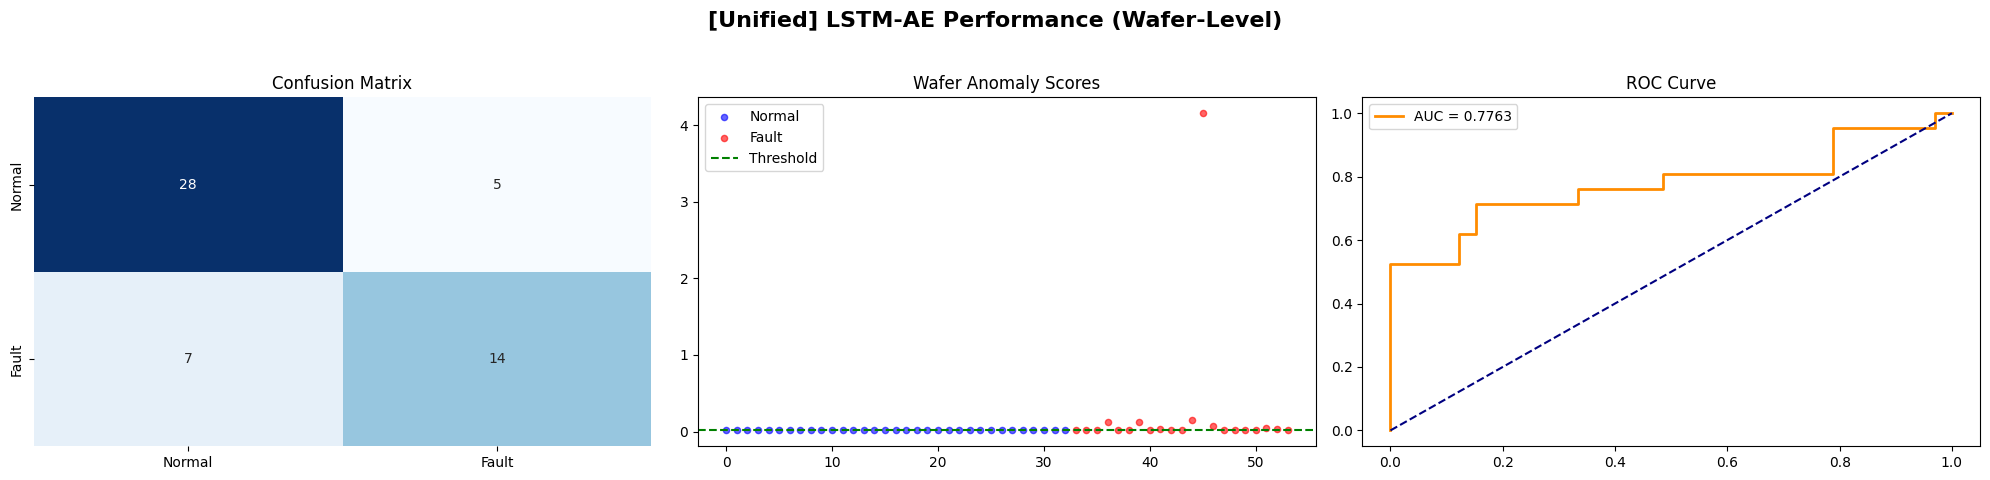


🚀 Training TranAD...
Epoch 5 Loss: 0.004770
Epoch 10 Loss: 0.001473
Epoch 15 Loss: 0.000582

📌 [TranAD - Unified] Wafer-Level Summary
   - AUROC         : 0.8528
   - Best F1-Score : 0.7895
   - Best Threshold: 0.000369


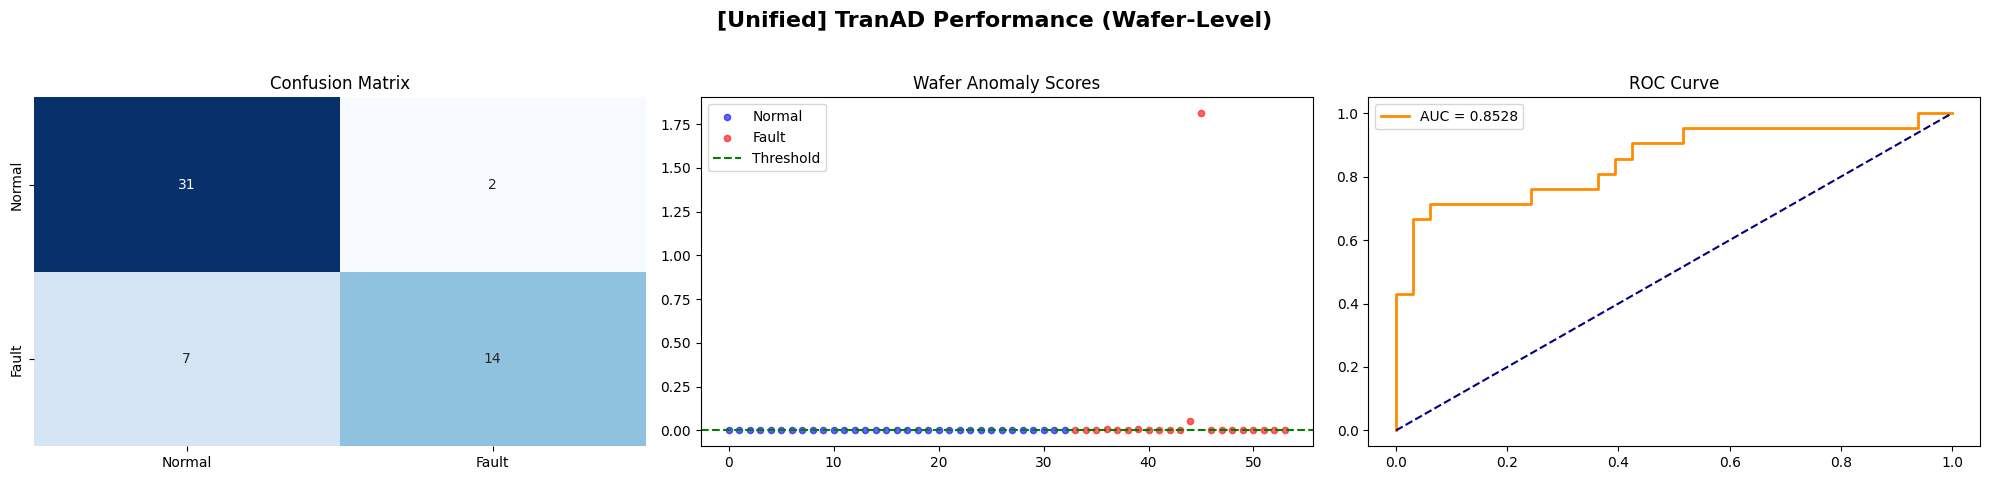


🚀 Training 1D ResNet (Supervised)...

📌 [1D-ResNet - Unified] Wafer-Level Summary
   - AUROC         : 0.9625
   - Best F1-Score : 0.9302
   - Best Threshold: 0.999915


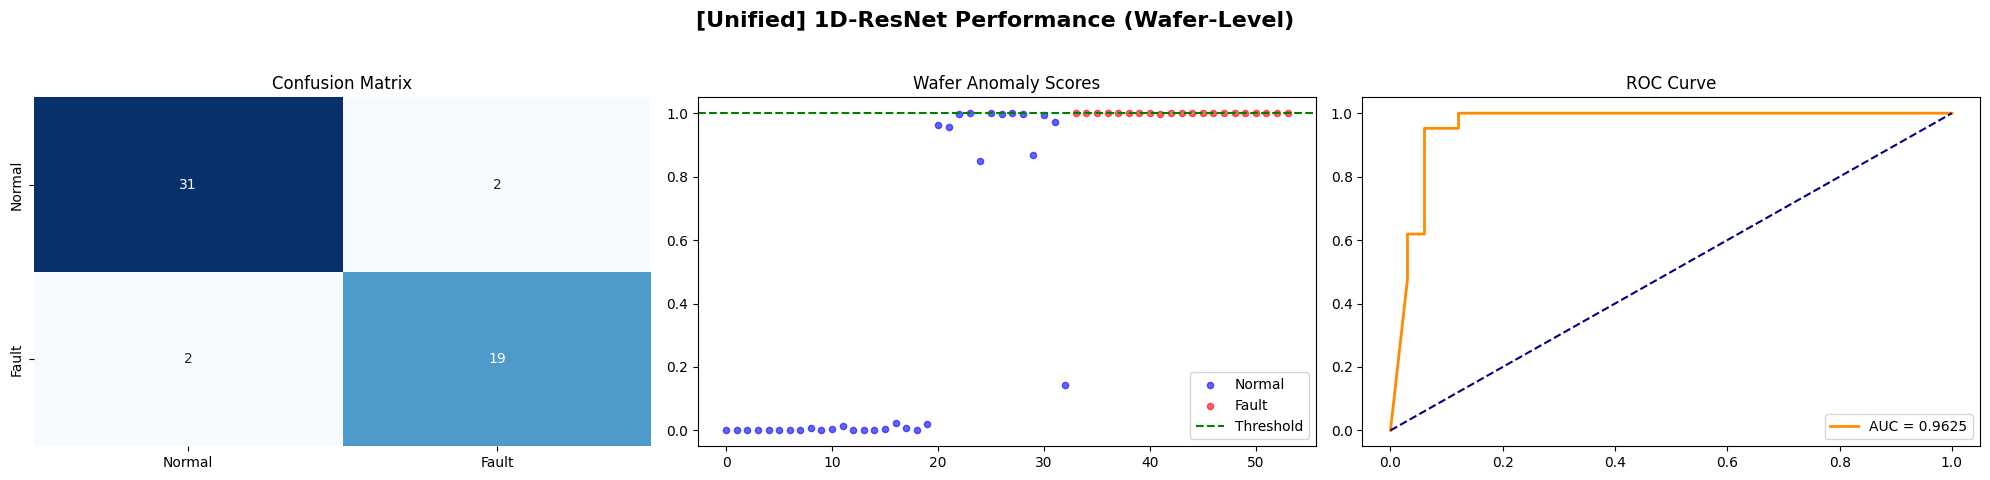

(np.float64(0.9624819624819625), np.float64(0.9302325581395349))

In [21]:
# 하이퍼파라미터
BATCH_SIZE = 32
NUM_EPOCHS = 15
LEARNING_RATE = 0.001
exp_id = 'Unified'

# 데이터 로드
train_loader, (test_norm, ids_norm), (test_fault, ids_fault) = get_data_loaders(exp_id, datasets, BATCH_SIZE)
n_features = test_norm.shape[2]
seq_len = test_norm.shape[1]

# ==========================================
# [모델 1 & 2] 비지도 학습 (Reconstruction)
# ==========================================
unsup_models = {
    "LSTM-AE": LSTM_AE(n_features, seq_len),
    "TranAD": TranAD(n_features, seq_len)
}

for name, model in unsup_models.items():
    print(f"\n🚀 Training {name}...")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.MSELoss()

    model.train()
    for epoch in range(NUM_EPOCHS):
        l = 0
        for (batch_x,) in train_loader:
            optimizer.zero_grad()
            recon = model(batch_x)
            loss = criterion(recon, batch_x)
            loss.backward()
            optimizer.step()
            l += loss.item()
        if (epoch+1) % 5 == 0: print(f"Epoch {epoch+1} Loss: {l/len(train_loader):.6f}")

    # 추론 & 웨이퍼 집계
    model.eval()
    with torch.no_grad():
        score_n = torch.mean((model(test_norm) - test_norm)**2, dim=[1,2]).cpu().numpy()
        score_f = torch.mean((model(test_fault) - test_fault)**2, dim=[1,2]).cpu().numpy()

    _, w_score_n = aggregate_wafer_scores(score_n, ids_norm, method='max')
    _, w_score_f = aggregate_wafer_scores(score_f, ids_fault, method='max')

    final_scores = np.concatenate([w_score_n, w_score_f])
    final_labels = np.concatenate([np.zeros(len(w_score_n)), np.ones(len(w_score_f))])
    evaluate_performance(name, exp_id, final_scores, final_labels)

# ==========================================
# [모델 3] 지도 학습 (ResNet1D Classification)
# ==========================================
print(f"\n🚀 Training 1D ResNet (Supervised)...")

# 지도학습용 데이터 재구성 (정상과 불량을 합쳐서 학습/검증 분할 필요)
# 여기서는 시연을 위해 train_loader의 정상 데이터와 test_fault의 일부를 사용하여 지도학습용 셋을 만듭니다.
X_sup = torch.cat([test_norm[:len(test_fault)], test_fault], dim=0)
Y_sup = torch.cat([torch.zeros(len(test_fault)), torch.ones(len(test_fault))], dim=0)
sup_loader = DataLoader(TensorDataset(X_sup, Y_sup), batch_size=BATCH_SIZE, shuffle=True)

resnet = ResNet1D(n_features).to(device)
optimizer = optim.Adam(resnet.parameters(), lr=LEARNING_RATE)
criterion = nn.BCELoss()

resnet.train()
for epoch in range(NUM_EPOCHS):
    for bx, by in sup_loader:
        optimizer.zero_grad()
        pred = resnet(bx).squeeze()
        loss = criterion(pred, by.to(device))
        loss.backward()
        optimizer.step()

# 추론 & 웨이퍼 집계 (확률값을 이상 점수로 사용)
resnet.eval()
with torch.no_grad():
    score_n = resnet(test_norm).cpu().numpy().flatten()
    score_f = resnet(test_fault).cpu().numpy().flatten()

_, w_score_n = aggregate_wafer_scores(score_n, ids_norm, method='max')
_, w_score_f = aggregate_wafer_scores(score_f, ids_fault, method='max')

final_scores = np.concatenate([w_score_n, w_score_f])
final_labels = np.concatenate([np.zeros(len(w_score_n)), np.ones(len(w_score_f))])
evaluate_performance("1D-ResNet", exp_id, final_scores, final_labels)